<a href="https://colab.research.google.com/github/rahiakela/kaggle-competition-projects/blob/master/google-ai4code/01_exploratory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Google AI4Code: Exploratory Data Analysis



**Exploratory data analysis is the work of a detective. Understanding the possibilities of your data is the first step in laying the groundwork for future modeling. With this notebook, we try to make sense of our data and demonstrate how data can be analyzed. We'll look for trends, limitations, and other characteristics linked to the questions we're interested in as part of our investigation.**

Reference:

https://www.kaggle.com/code/andreaspalmgren/ai4code-comprehensive-eda

##Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import re
import os

pd.options.display.width = 180
pd.options.display.max_colwidth = 100

rc = {"axes.spines.left" : True,
      "axes.spines.right" : False,
      "axes.spines.bottom" : True,
      "axes.spines.top" : False,
      "xtick.bottom" : True,
      "xtick.labelbottom" : True,
      "ytick.labelleft" : True,
      "ytick.left" : True,
      "figure.subplot.hspace" : 0.7,
    "figure.titleweight" : "bold",
    "axes.titleweight" : "bold",
     "font.weight" : "bold"}
plt.rcParams.update(rc)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
# content/gdrive/My Drive/Kaggle is the path where kaggle.json is  present in the Google Drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle-keys"

In [4]:
%%shell

# download dataset from kaggle> URL: https://www.kaggle.com/competitions/AI4Code
kaggle competitions download -c AI4Code

unzip -qq AI4Code.zip
rm -rf AI4Code.zip

 97% 690M/714M [00:04<00:00, 185MB/s]
100% 714M/714M [00:04<00:00, 169MB/s]


In [5]:
%%shell

mkdir AI4Code
mv train AI4Code
mv test AI4Code
mv train_orders.csv AI4Code
mv train_ancestors.csv AI4Code

##Data Source

**Google and X, the moonshot factory, have supplied the dataset, which contains about 160 000 Jupyter notebooks. This is part of a <a href="https://www.kaggle.com/competitions/AI4Code">Kaggle competition</a> to train a model that can rank markdown cells depending on the order of its code cells. 

Code cells are written in python and markdown cells are written in markdown, which is the text formatting langague used in Jupyter.**

In [6]:
def read_notebook(path):
  return (
      pd.read_json(path, dtype={"cell_type": "category", "source": "str"})
        .assign(id=path.stem)
        .rename_axis("cell_id")
  )

In [7]:
data_dir = Path("./AI4Code")
# Subset of training due to its large size
NUM_TRAIN = 20000

paths_train = list((data_dir / "train").glob("*.json"))[:NUM_TRAIN]

notebooks_train = [read_notebook(path) for path in tqdm(paths_train, desc="Train NBs")]
# Get notebooks
df_notebooks = (
    pd.concat(notebooks_train)
      .set_index("id", append=True)
      .swaplevel()
      .sort_index(level="id", sort_remaining=False)
  )

# Get correct order of cells in notebooks
df_orders = pd.read_csv(data_dir / "train_orders.csv", index_col="id")
df_orders = df_orders.squeeze().str.split(" ").explode().to_frame()
df_orders["rank"] = pd.Series([np.arange(x) for x in df_orders.groupby("id").count()["cell_order"]]).explode().to_numpy()

df = df_notebooks.reset_index().merge(df_orders.reset_index().rename(columns={"cell_order": "cell_id"}), how="inner", on=["id", "cell_id"])

# Get ancestors for notebooks
df_ancestors = pd.read_csv(data_dir / "train_ancestors.csv", index_col="id")

# Final combined dataframe
df = df.merge(df_ancestors, on="id").sort_values(["id", "rank"]).set_index(["id", "cell_id"])

# Dataframe for count information - Used in EDA
mkd = df[df["cell_type"] == "markdown"].groupby(by=["id"]).count().source
code = df[df["cell_type"] == "code"].groupby(by=["id"]).count().source
df_counts = pd.concat([mkd, code], axis=1)
df_counts.columns = ["markdown_count", "code_count"]
df_counts["tot"] = df_counts.markdown_count + df_counts.code_count
df_counts["ratio"] = df_counts.code_count / df_counts.tot

Train NBs: 100%|██████████| 20000/20000 [01:36<00:00, 206.70it/s]


Training data consists out of 140 000 JSON files, each containing a notebook where markdown cells have been shuffeled. Additional files regarding correct markdown order, as well as, information of "forked notebook" has also been given. Following table is a combination of all given training files, including the correct order and ancestor_id/parent_id.

* **`id` - Unique identification of notebook.** 
* **`cell_id` - Unique identification of cell within notebooks.** 
* **`cell_type` - Factor specifying cell type, either being a code cell or markdown cell.** 
* **`source` - String with content of cell.**
* **`rank` - Order rank for given cell within notebook.**
* **`ancestor_id` - Identifies sets of notebooks with common origin.**
* **`parent_id` - Some version of the notebook id was forked from some version of the notebook `parent_id`. It may or may not be present (i.e. `parent_id` may be missing due to someone having forked a private notebook).** 

In [8]:
df.head()

cell_type                                                                                               source rank ancestor_id parent_id
id             cell_id                                                                                                                                           
0001daf4c2c76d 97266564  markdown  #                                    Comprehensive Guide to--Matplotlib / Seaborn / Plotly\n\nMa...    0    090152ca       NaN
               a898e555  markdown  # Table of Contents\n\n* [Section  1 - Importing matplotlib & Classic Graph](#section-one)  \n* ...    1    090152ca       NaN
               86605076      code  # This Python 3 environment comes with many helpful analytics libraries installed\n# It is defin...    2    090152ca       NaN
               76cc2642  markdown  Importing matplotlib\nJust as we use the np shorthand for NumPy and the pd shorthand for Pandas,...    3    090152ca       NaN
               ef279279  markdown                        <a id="section-one"></a>\n# Section  1 - Importing matplotlib & Classic Graph    4    090152ca       NaN

**We're in luck because the competition organizers have already cleaned the dataset. It has been stated that:** 

* **Notebooks contain at least one of each `cell_type`, meaning notebooks should have a length of 2 or more.** 
- **Any cells with empty `source` have already have been removed.**  
- **All code is written in python.** 

**Before continuing with the analysis, we need to make a short check on our own. `cell_type` is a factor that specifies one of two cell types: markdown or code. Only these two types appear to be present in the data, which is good.**

In [9]:
df["cell_type"].unique()

array(['markdown', 'code'], dtype=object)

**We should not have any missing values, excpet within `parent_id`. Since the data appears to be clean, it is time to start our analysis.**

In [10]:
df.isna().sum()

cell_type           0
source              0
rank                0
ancestor_id         0
parent_id      798720
dtype: int64

##Data Analysis

**Analysis will be based on a subset of the training data (20 000 notebooks).**

###Code vs. Markdown

**We now possess enough information to begin our analysis. Due to the fact that our model aims to order markdown cells based on code cells, the relationship between the two is of primary importance. A great starting point is to display the proportion of cell types across all notebooks. As seen in the pie chart below, code cells appear to be far more common than markdown cells which give us plenty to work on.**

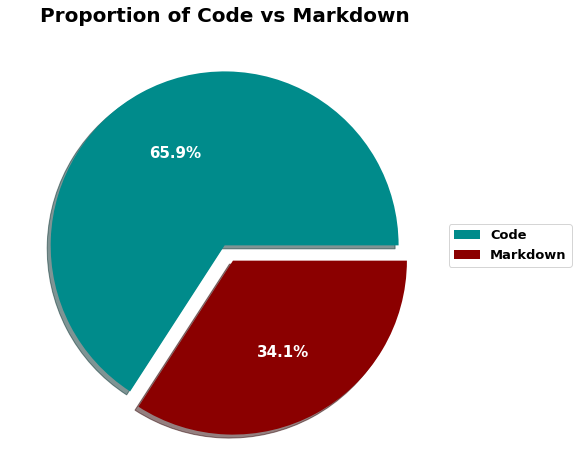

In [11]:
fig1, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie([df_counts.code_count.sum(), df_counts.markdown_count.sum()],
                                  shadow=True,
                                  explode=(0, 0.1),
                                  labels=["Code", "Markdown"],
                                  autopct="%1.1f%%",
                                  textprops=dict(color="w"),
                                  colors=["#008b8b", "#8b0000"])
plt.setp(autotexts, size=15, weight="bold")
ax.legend(wedges, ["Code", "Markdown"], loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), prop={"size": 13})
ax.set_title("Proportion of Code vs Markdown", size=20);

> **Another intuitive plot is the number of cells in a notebook as a measure of its length. The histogram below displays the sample distribution for notebook lengths and it appears to be right-skewed. The average notebook contains 30-40 cells, whereas some notebooks contain a couple hundred.**

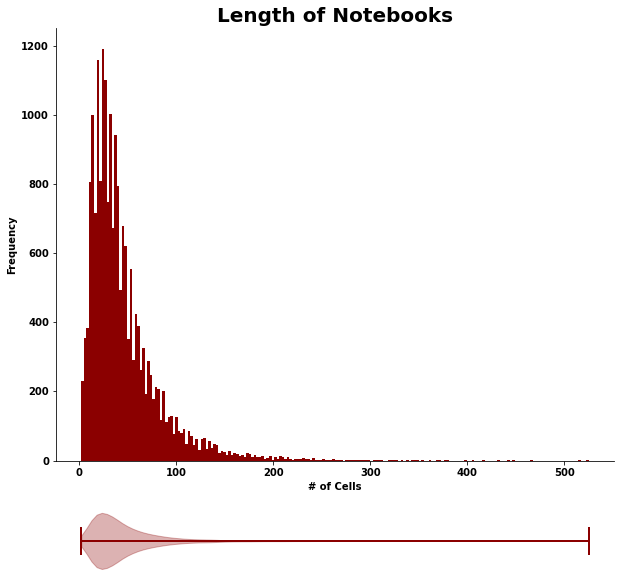

In [12]:
fig, axs = plt.subplots(2, figsize=(10,10), gridspec_kw={"height_ratios": [7, 1]})
fig.subplots_adjust(hspace=0.2)

count = df.groupby(by=["id"]).count()["source"].values
axs[0].hist(count, bins=200, color="#8b0000")

axs[0].set_xlabel("# of Cells", weight="bold")
axs[0].set_ylabel("Frequency", weight="bold")
axs[0].set_title(f"Length of Notebooks", size=20);

violin_parts = axs[1].violinplot(count, vert=False);
for part in violin_parts['bodies']:
    part.set_facecolor("#8b0000")
    part.set_edgecolor("#8b0000")
    
for partname in ('cbars','cmins','cmaxes'):
    vp = violin_parts[partname]
    vp.set_edgecolor("#8b0000")
    vp.set_linewidth(2)

# Hide axis spine, ticks
for txt in ["top","right","left","bottom"]:
        axs[1].spines[txt].set_visible(False)
axs[1].xaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

> **In our case, the central tendency is best described by the median.**

In [14]:
print(" \033[1m", "Median of Notebook lengths: ", np.median(count), "\033[0m")
print("\n \033[1m", "Most frequenct Notebook length: ", df_counts.tot.value_counts().idxmax(), "\033[0m")

  Median of Notebook lengths:  35.0 

  Most frequenct Notebook length:  21 


> **We can examine notebook length once more, but this time compare the sample distribution of code and markdown cells. A large spike for markdown cells can be seen in the ridge plot below.**  

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [1, 7]})
fig.subplots_adjust(wspace=0.01, hspace=-0.9)

colors=["#8b0000", "#008b8b"]
